In [ ]:
!git clone https://github.com/tianyi-lab/CoSTAR.git
%cd CoSTAR

## Visualize Input Image and the Prompt

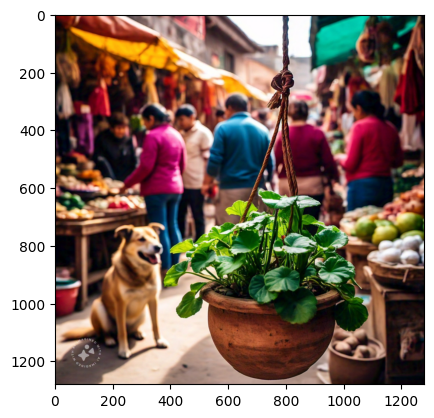

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML

img = Image.open("40.jpeg")
prompt_text2 = "Input Image:"
html_text2 = f"<div style='font-size: 18px;'>{prompt_text2}</div>"
display(HTML(html_text2))
plt.imshow(np.array(img))
plt.axis('on')
plt.show()
print("\n")
input_prompt = "40.txt"

with open(input_prompt, 'r') as file:
    prompt_text = file.read()

prompt_text1 = "Input Prompt:"
html_text = f"<div style='font-size: 18px;'>{prompt_text}</div>"
html_text1 = f"<div style='font-size: 20px;'>{prompt_text1}</div>"

display(HTML(html_text1))
display(HTML(html_text))

## Generate Subtask Tree for the Task

In [ ]:
from subtask_tree import generate_subtask_tree
import json

# Set your OpenAI API key. Ensure you have access to api for the openAI o1 model
llm_api_key = "your_openai_api_key_here"

# Generate the subtask tree by calling the function.
subtask_tree_final = generate_subtask_tree(llm_api_key, img, prompt_text)

subtask_tree_json = json.dumps(subtask_tree_final, indent=4)
print(subtask_tree_json)

with open("Tree.json", "w") as f:
    f.write(subtask_tree_json)

{
    "task": "Segment the dog, detect the person, recolor the leaves to red, and expand the image.",
    "subtask_tree": [
        {
            "subtask": "Outpainting (1)",
            "parent": []
        },
        {
            "subtask": "Object Segmentation (Dog) (2)",
            "parent": [
                "Outpainting (1)"
            ]
        },
        {
            "subtask": "Object Detection (Person) (3)",
            "parent": [
                "Object Segmentation (Dog) (2)"
            ]
        },
        {
            "subtask": "Object Recoloration (Leaves -> Red Leaves) (4)",
            "parent": [
                "Object Detection (Person) (3)"
            ]
        },
        {
            "subtask": "Object Detection (Person) (2)",
            "parent": [
                "Outpainting (1)"
            ]
        },
        {
            "subtask": "Object Segmentation (Dog) (3)",
            "parent": [
                "Object Detection (Person) (2)"
         

### Visualize Subtask Tree as a graph image

In [ ]:
import json
import networkx as nx
import plotly.graph_objects as go
import plotly.express as px

def visualize_json_tree(json_data):
    try:
        subtask_tree = json_data.get("subtask_tree", [])
        if not subtask_tree:
            print("No subtask_tree found in the JSON data.")
            return

        graph = nx.DiGraph()

        for subtask_data in subtask_tree:
            subtask = subtask_data["subtask"]
            parents = subtask_data["parent"]
            graph.add_node(subtask)
            for parent in parents:
                graph.add_edge(parent, subtask)

        pos = nx.nx_pydot.graphviz_layout(graph, prog="dot")

        nodes = list(graph.nodes())
        node_x = [pos[node][0] for node in nodes]
        node_y = [pos[node][1] for node in nodes]

        edge_x = []
        edge_y = []
        edge_positions = []
        for edge in graph.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])
            edge_positions.append(((x0, y0), (x1, y1)))

        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=1.5, color='gray'),
            hoverinfo='none',
            mode='lines')

        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers',
            hoverinfo='text',
            text=nodes,
            marker=dict(
                color='rgb(255, 165, 0)',
                size=50,
                line=dict(width=2, color='DarkSlateGrey'))
        )

        fig = go.Figure(
            data=[edge_trace, node_trace],
            layout=go.Layout(
                title=dict(
                    text="Subtask Tree (Hover over node to see subtask name)",
                    x=0.5,
                    font=dict(size=20, color="black")
                ),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20, l=5, r=5, t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                height=400,
                width=800
            )
        )

        for (x0, y0), (x1, y1) in edge_positions:
            fig.add_annotation(
                x=x1,
                y=y1,
                ax=x0,
                ay=y0,
                xref="x",
                yref="y",
                axref="x",
                ayref="y",
                showarrow=True,
                arrowhead=3,
                arrowsize=1.5,
                arrowwidth=2,
                arrowcolor='black'
            )

        fig.show()

    except Exception as e:
        print(f"An error occurred: {e}")

with open('Tree.json', 'r') as f:
    json_data = json.load(f)
    visualize_json_tree(json_data)

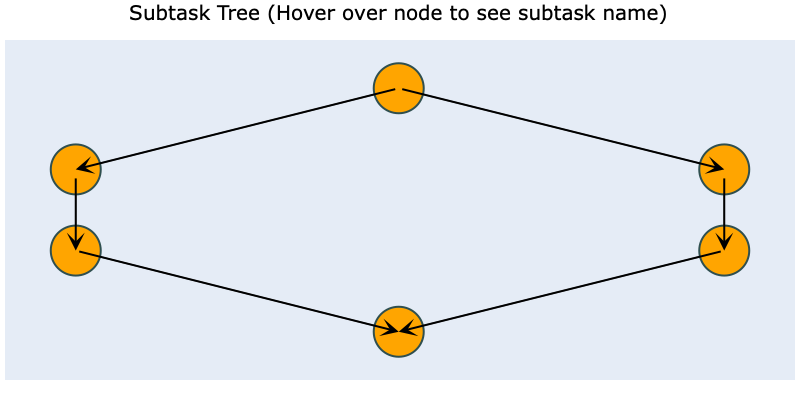

In [2]:
#Fallback visualization of the subtask tree
from IPython.display import display
from PIL import Image
subtask_tree_image = Image.open("/content/newplot.png")
display(subtask_tree_image)

## Generate Tool Subgraph from the Subtask Tree


In [ ]:
import json
import networkx as nx
from tool_subgraph import build_tool_subgraph_from_subtask_tree, visualize_and_save_graph_with_arrows
import matplotlib.pyplot as plt

# Load the subtask tree from Tree.json
with open("Tree.json", "r") as f:
    subtask_tree = json.load(f)

# Build the final tool subgraph from the loaded subtask tree.
final_graph = build_tool_subgraph_from_subtask_tree(subtask_tree)

print("=== Final Tool Subgraph ===")
for key, value in final_graph.items():
  print(f"{key}: {value}")


=== Final Tool Subgraph ===
Input Image: ['StabilityOutpaint (Outpainting ()(1))']
StabilityOutpaint (Outpainting ()(1)): ['YOLOv7 (Object Segmentation (Dog)(2))', 'GroundingDINO (Object Segmentation (Dog)(2))', 'YOLOv7 (Object Detection (Person)(2))', 'GroundingDINO (Object Detection (Person)(2))']
YOLOv7 (Object Segmentation (Dog)(2)): ['SAM (Object Segmentation (Dog)(2))']
GroundingDINO (Object Segmentation (Dog)(2)): ['SAM (Object Segmentation (Dog)(2))']
SAM (Object Segmentation (Dog)(2)): ['YOLOv7 (Object Detection (Person)(3))', 'GroundingDINO (Object Detection (Person)(3))']
YOLOv7 (Object Detection (Person)(3)): ['YOLOv7 (Object Recoloration (Leaves -> Red Leaves)(4))', 'GroundingDINO (Object Recoloration (Leaves -> Red Leaves)(4))', 'StabilitySearchRecolor (Object Recoloration (Leaves -> Red Leaves)(4))']
GroundingDINO (Object Detection (Person)(3)): ['YOLOv7 (Object Recoloration (Leaves -> Red Leaves)(4))', 'GroundingDINO (Object Recoloration (Leaves -> Red Leaves)(4))', 'St

### Visualize Tool Subgraph

In [ ]:
import networkx as nx
import plotly.graph_objects as go

def visualize_tool_subgraph(tool_subgraph):
    """
    Takes a dictionary where keys are tasks and values are lists of dependent tasks,
    and visualizes it as a directed graph.
    """
    try:
        if not tool_subgraph:
            print("The input dictionary is empty.")
            return

        graph = nx.DiGraph()

        for parent, children in tool_subgraph.items():
            graph.add_node(parent)
            for child in children:
                graph.add_node(child)
                graph.add_edge(parent, child)

        pos = nx.nx_pydot.graphviz_layout(graph, prog="dot")

        nodes = list(graph.nodes())
        node_x = [pos[node][0] for node in nodes]
        node_y = [pos[node][1] for node in nodes]

        edge_x = []
        edge_y = []
        edge_positions = []
        for edge in graph.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])
            edge_positions.append(((x0, y0), (x1, y1)))

        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=1.5, color='gray'),
            hoverinfo='none',
            mode='lines'
        )

        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers',
            hoverinfo='text',
            text=nodes,
            marker=dict(
                color='rgb(255, 165, 0)',
                size=50,
                line=dict(width=2, color='DarkSlateGrey'))
        )

        fig = go.Figure(
            data=[edge_trace, node_trace],
            layout=go.Layout(
                title=dict(
                    text="Tool Subgraph (Hover over node to see subtask name)",
                    x=0.5,
                    font=dict(size=20, color="black")
                ),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20, l=5, r=5, t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                height=600,
                width=1000
            )
        )

        for (x0, y0), (x1, y1) in edge_positions:
            fig.add_annotation(
                x=x1,
                y=y1,
                ax=x0,
                ay=y0,
                xref="x",
                yref="y",
                axref="x",
                ayref="y",
                showarrow=True,
                arrowhead=3,
                arrowsize=1,
                arrowwidth=1.8,
                arrowcolor='black'
            )

        fig.show()

    except Exception as e:
        print(f"An error occurred: {e}")

visualize_tool_subgraph(final_graph)

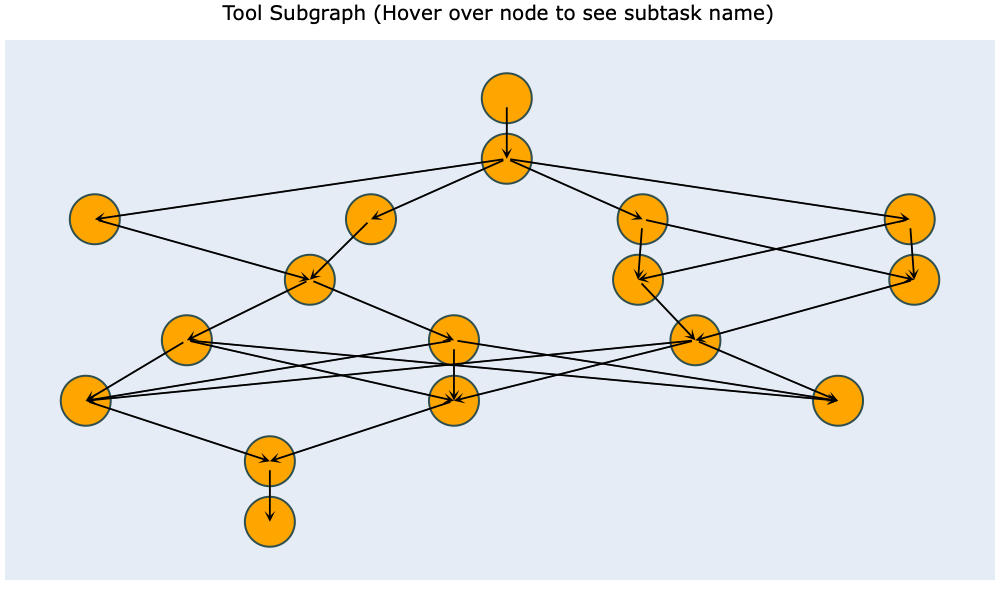

In [3]:
#Fallback visualization of the Tool Subgraph
tool_subgraph_image = Image.open("/content/newplot-2.png")
display(tool_subgraph_image)

## Do A* Search on Tool Subgraph and generate the final output

Optimal path: ['StabilityOutpaint (Outpainting ()(1))', 'GroundingDINO (Object Segmentation (dog)(2))', 'SAM (Object Segmentation (dog)(2))', 'GroundingDINO (Object Detection (person)(3))', 'StabilitySearchRecolor (Object Recoloration (Leaves -> Red Leaves)(4))']

Input Image:


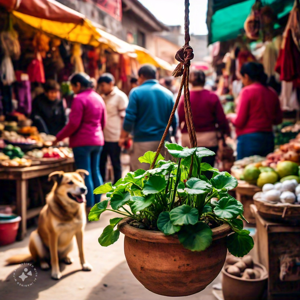


Input Prompt: Segment the dog, detect the person, recolor the leaves to red, and expand the image


Outputs along the optimal path:

Output for node StabilityOutpaint (Outpainting ()(1)):
We use StabilityOutpaint for performing outpainting as part of the Outpainting subtask.
The output image is expanded.


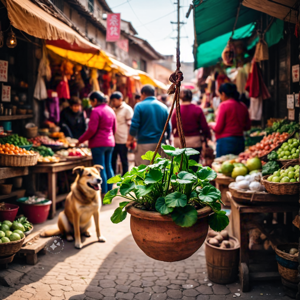



Output for node GroundingDINO (Object Segmentation (dog)(2)):
We use GroundingDINO for detecting dog as part of the Object Segmentation subtask.
The output image has a bounding box drawn around dog.


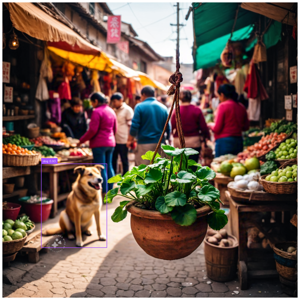



Output for node SAM (Object Segmentation (dog)(2)):
We use SAM for segmenting dog as part of the Object Segmentation subtask.
The output image has a mask around dog.


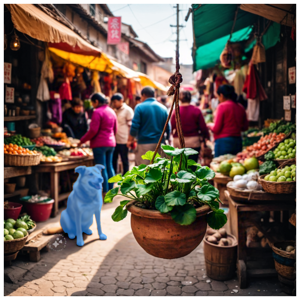



Output for node GroundingDINO (Object Detection (person)(3)):
We use GroundingDINO for detecting person as part of the Object Detection subtask.
The output image has a bounding box drawn around person.


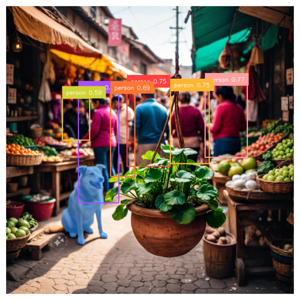



Output for node StabilitySearchRecolor (Object Recoloration (Leaves -> Red Leaves)(4)):
We use StabilitySearchRecolor for recoloring Leaves -> Red Leaves as part of the Object Recoloration subtask.
The Leaves has been recolored to Red in the output image.


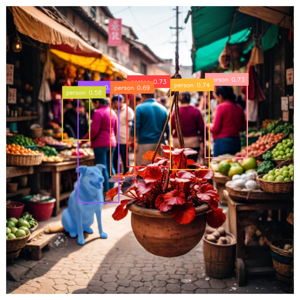




FINAL OUTPUT: 


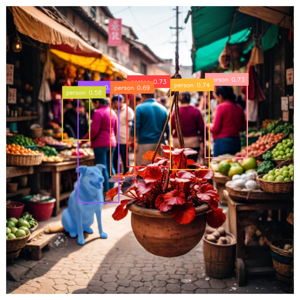

In [ ]:
import json
import networkx as nx
from IPython.display import display
from PIL import Image
from main import ToolPipeline
from astar_search import a_star_search
import re

import os
# Replace 'your_api_key_here' with your actual API key for StabilityAI in order to run Stable Diffusion Models.
os.environ['STABILITY_API_KEY'] = 'your_api_key_here'

# ------------------------------
# Parameters and Initialization
# ------------------------------
alpha = 0
quality_threshold = 0.88

# Load the original input image
original_inputs = {"image": img}

# Create a pipeline instance using the YAML configuration.
pipeline = ToolPipeline("configs/tools.yaml", auto_install=True)

# ------------------------------
# Run A* Search
# ------------------------------
# Call the A* search function. It should return the optimal path (a list of node names),
# the final state (which includes the final output image under key "image"),
# and the local memory (a dictionary with outputs keyed by node names).
optimal_path, final_state, local_memory = a_star_search(
    final_graph,
    alpha,
    quality_threshold,
    original_inputs,
    prompt_text,
    pipeline
)

print("Optimal path:", optimal_path)

# Get and display the final output image.
final_image = final_state.get("image")
if final_image:
    output_path = "/content/final.png"
    final_image.save(output_path)
else:
    print("Final image not available.")

#Some sample config for printing output explanations for certain subtasks
model_config = {
    "StabilityOutpaint": {"action": "performing outpainting", "task_type": "outpaint"},
    "GroundingDINO": {"action": "detecting", "task_type": "detection"},
    "SAM": {"action": "segmenting", "task_type": "segmentation"},
    "StabilitySearchRecolor": {"action": "recoloring", "task_type": "recoloration"}
}

# ------------------------------
# Display Outputs from Each Node on the Optimal Path
# ------------------------------
print("\nInput Image:")
display(img.resize((300, 300)))
print(f"\nInput Prompt: {prompt_text}\n")

print("\nOutputs along the optimal path:")
for node in optimal_path[1:]:
    output = local_memory.get(node)
    print(f"\nOutput for node {node}:")
    model, remainder = node.split(' (', 1)
    task_part = remainder.rsplit(')', 1)[0]

    match = re.match(r"^(.*?)\s*\((.*?)\)\s*\((\d+)\)?$", task_part)

    if match:
        task_type = match.group(1).strip()
        obj = match.group(2).strip()
        config = model_config.get(model, {})
        action = config.get("action", "processing")

        # First explanation line
        explanation = f"We use {model} for {action}"
        if obj:
            explanation += f" {obj}"
        explanation += f" as part of the {task_type} subtask."
        print(explanation)

        # Second task-specific line
        task_category = config.get("task_type")
        if task_category:
            if "->" in obj:
                from_obj, target_obj = map(str.strip, obj.split("->", 1))
            else:
                from_obj = obj.strip()
                target_obj = None

            if task_category == "detection":
                print(f"The output image has a bounding box drawn around {from_obj}.")
            elif task_category == "segmentation":
                print(f"The output image has a mask around {from_obj}.")
            elif task_category == "recoloration" and target_obj:
                object1 = target_obj.replace(from_obj, "", 1).strip()
                print(f"The {from_obj} has been recolored to {object1} in the output image.")
            elif task_category == "outpaint":
                print(f"The output image is expanded.")

    if isinstance(output, dict):
        img = output.get("image")
        if img:
            display(img.resize((300, 300)))
            print("\n")
        else:
            print("No image found in output.")
    elif isinstance(output, Image.Image):
        display(output)
        print("\n")
    else:
        print("Output:", output)

print("\nFINAL OUTPUT: ")
display(final_image.resize((300, 300)))